## Quantum State Tomography Test

$\rho = \frac {1} {2} (I + \vec {r} \cdot {\vec {\sigma}}) = \begin{pmatrix} 1 + r_z & r_x - ir_y \\ r_x + ir_y & 1 - r_z \end{pmatrix}$

$\vec {r} = (r_x, r_y, r_z), \vec{\sigma} = (X,Y,Z)$

$X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} , Y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}, Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$

$\braket{X} = Tr\{X\rho\} \\
= Tr\{X \frac{1} {2} ( I + r_xX + r_yY + r_zZ)\} \\
= \frac{1} {2} Tr \{X + r_xX^2 + r_yXY + r_zXZ\} \\
= \frac {1} {2} r_x Tr\{I\} \\
= r_x$

$\braket{Y} = Tr\{Y\rho\} \\
= Tr\{Y \frac{1} {2} ( I + r_xX + r_yY + r_zZ)\} \\
= \frac{1} {2} Tr \{Y + r_xYX + r_yY^2 + r_zYZ\} \\
= \frac {1} {2} r_y Tr\{I\} \\
= r_y$

$\braket{Z} = Tr\{Z\rho\} \\
= Tr\{Z \frac{1} {2} ( I + r_xX + r_yY + r_zZ)\} \\
= \frac{1} {2} Tr \{Z + r_xZX + r_yZY + r_zZ^2\} \\
= \frac {1} {2} r_z Tr\{I\} \\
= r_z$

In [7]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# Defining sequence of shots
shot = [10, 100, 1000, 10000, 100000]

# Rotation parameters
phi = np.pi/4
theta = np.pi/3

# Device declaration
dev = qml.device('default.mixed', wires = 1, shots = shot)

test_dev = qml.device('default.mixed', wires = 1, shots = None)

In [8]:
# Density matrix for comparing
@qml.qnode(test_dev)
def prepare_state():
    qml.RX(phi, wires=0)
    qml.RY(theta, wires=0)

    return qml.density_matrix(wires=0)

# Define 3 measuring functions. Each corresponds to Pauli X, Y, Z
@qml.qnode(dev)
def measure_x():
    qml.RX(phi, wires=0)
    qml.RY(theta, wires=0)

    return qml.expval(qml.PauliX(wires=0))

@qml.qnode(dev)
def measure_y():
    qml.RX(phi, wires=0)
    qml.RY(theta, wires=0)

    return qml.expval(qml.PauliY(wires=0))

@qml.qnode(dev)
def measure_z():
    qml.RX(phi, wires=0)
    qml.RY(theta, wires=0)

    return qml.expval(qml.PauliZ(wires=0))

# Simple Quantum State Tomography
def QST():

    # Measure expected values
    mx = measure_x()
    my = measure_y()
    mz = measure_z()

    # Define 3 pauli matrices
    pauliX = np.array([[0,1],[1,0]])
    pauliY = np.array([[0,-1j],[1j,0]])
    pauliZ = np.array([[1,0],[0,-1]])

    # Determine coordinates on bloch sphere
    estimate = np.array([[mx[i], my[i], mz[i]] for i in range(len(shot))])

    # normalize the state
    for i in range(len(shot)):
        estimate[i] = estimate[i] / np.linalg.norm(estimate[i])

    # calculate density matrix according to the formula above
    dm_estimate = np.array([(np.eye(2) + e[0] * pauliX + e[1] * pauliY + e[2] * pauliZ)/2 for e in estimate])

    return dm_estimate

# calculate fidelity
def calculate_fidelity(original, estimate):

    return np.array([qml.math.fidelity(original, entry) for entry in estimate])

In [9]:
original = prepare_state()
estimate = QST()

result = calculate_fidelity(original, estimate)
result

array([0.98289459, 0.98554677, 0.99995327, 0.99998342, 0.99999439])

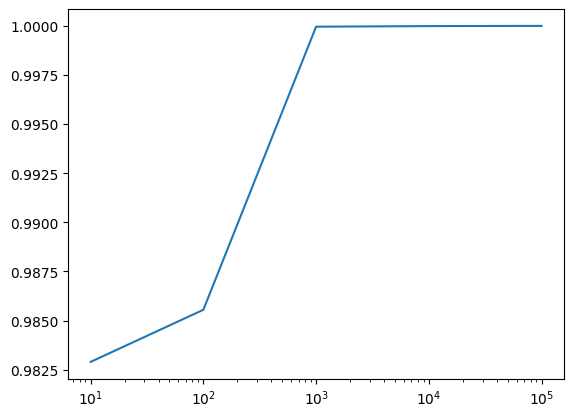

In [10]:
plt.plot(shot, result)
plt.xscale('log')
plt.show()

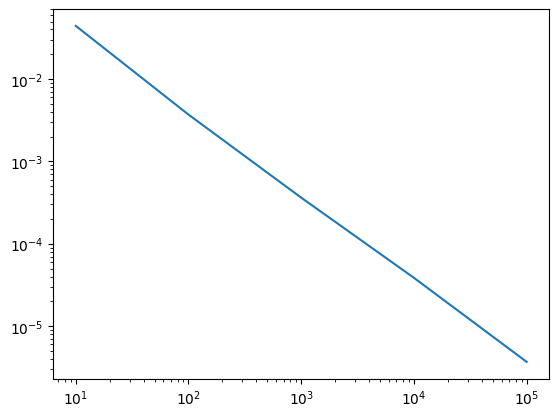

In [12]:
trial = 1000

results = np.zeros((trial, len(shot)))

for i in range(trial):
    original = prepare_state()
    estimate = QST()
    res = calculate_fidelity(original, estimate)
    results[i] = res

variances = np.array([np.std(results[:,i]) for i in range(len(shot))])

# Plot reliability
plt.cla()
plt.plot(shot, variances)
plt.xscale('log')
plt.yscale('log')
plt.show()